In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
TRAIN_DIR = '/content/gdrive/My Drive/knn_data/testing-siacnn'
TEST_DIR = '/content/gdrive/My Drive/knn_data/train-siacnn'

device = torch.device('cuda:0' if (torch.cuda.is_available()) else 'cpu')

In [ ]:
BATCH_SIZE = 31
N_EPOCHS = 80
LR = 0.0005
N_GPU = 1
SET_L = True
INPUT_D = 3 if SET_L == False else 1

# Augmenting Data

In [ ]:
# Rotating random images by 90 degress and flipping them horizontally to check the accuracy of results 
class AugmentData:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

In [ ]:
transform = transforms.Compose([ transforms.Resize((100,100)), AugmentData(angles=[0, 90]), transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Creating data set for training

In [ ]:
# Selecting 2 images randomnly from the dataset, extracting their labels, transforming them and returning the 2 images
class SiameseDataset(torch.utils.data.Dataset):

    def __init__(self, datasets):
        self.datasets = datasets
        self.train = True
        self.transform = None
        self.should_invert = True
        self.set_luminance = True
        
    def __getitem__(self, index):
        imageA_tupple = random.choice(self.datasets.imgs)
        class1 = random.randint(0,1)
        if class1:
            while True:
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] == imageB_tupple[1]:
                    break
        else:
            while True:
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] != imageB_tupple[1]:
                    break
                    
        imageA = Image.open(imageA_tupple[0])
        imageB = Image.open(imageB_tupple[0])
        
        if self.set_luminance:
            imageA = imageA.convert('L')
            imageB = imageB.convert('L')
        
        if self.should_invert:
            imageA = ImageOps.invert(imageA)
            imageB = ImageOps.invert(imageB)
            
        if self.transform is not None:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)
        
        if self.train:
            return imageA, imageB, torch.from_numpy(np.array([int(imageA_tupple[1] != imageB_tupple[1])],dtype=np.float32))
        else:
            return imageA, imageA_tupple[0], imageA_tupple[1], imageB, imageB_tupple[0], imageB_tupple[1]
        
    def __len__(self):
        return len(self.datasets.imgs)

In [ ]:
datasets = torchvision.datasets.ImageFolder(root=TRAIN_DIR)

siamese_datasets = SiameseDataset(datasets=datasets, transform=transform,
                                  should_invert=False, set_luminance=SET_L)

Load_train_data = DataLoader(siamese_datasets, shuffle=True,
                          num_workers=0, batch_size=BATCH_SIZE)

# SIAMESE CNN ARCHITECTURE

In [ ]:
# Defining the architecture of the convolutional neural network
class Arch_Siamese(nn.Module):
    
    def __init__(self):
        super(Arch_Siamese, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(INPUT_D, 4, kernel_size=3),
            nn.ReLU(),        
            nn.ZeroPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(),
            nn.ZeroPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(),
            )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 5),
            )
    
    def forward_once(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA)
        resultB = self.forward_once(imageB)
        
        return resultA, resultB

siamese = Arch_Siamese().to(device)

In [ ]:
# Defining loss function to minimize during training
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, resultA, resultB, label):
        euclidean_distance = 0.5*F.pairwise_distance(resultA, resultB, keepdim=True) 
        
        contrastive_loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return contrastive_loss

contrastive_loss = ContrastiveLoss()

# Training the model with train data ( No pre processing )

In [ ]:
train_loss = 0
Loss_training = []
optimizer = optim.Adam(siamese.parameters(), lr=LR)
N = len(datasets)

for epoch in range(N_EPOCHS):
    for batch_idx, data in enumerate(Load_train_data):
        imageA, imageB, label = data
        imageA, imageB, label = imageA.to(device), imageB.to(device), label.to(device)
        
        optimizer.zero_grad()
        resultA, resultB = siamese(imageA, imageB)
        loss = contrastive_loss(resultA, resultB, label)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    BatchCount_PER_EPOCH = N//BATCH_SIZE
    train_loss = train_loss/BatchCount_PER_EPOCH
    Loss_training.append(train_loss)
    
    print('Train Epoch:{}\t\tLoss:{:.6f}'.format(epoch+1, train_loss))
    train_loss = 0
    siamese.train()

Train Epoch:1		Loss:1.809520
Train Epoch:2		Loss:1.533890
Train Epoch:3		Loss:1.254770
Train Epoch:4		Loss:1.233212
Train Epoch:5		Loss:1.238176
Train Epoch:6		Loss:1.203535
Train Epoch:7		Loss:1.072955
Train Epoch:8		Loss:1.240366
Train Epoch:9		Loss:1.231284
Train Epoch:10		Loss:1.186080
Train Epoch:11		Loss:1.176442
Train Epoch:12		Loss:1.131547
Train Epoch:13		Loss:1.154468
Train Epoch:14		Loss:1.198337
Train Epoch:15		Loss:1.111738
Train Epoch:16		Loss:1.122685
Train Epoch:17		Loss:1.082279
Train Epoch:18		Loss:1.088972
Train Epoch:19		Loss:1.044031
Train Epoch:20		Loss:1.026970
Train Epoch:21		Loss:1.035295
Train Epoch:22		Loss:1.036052
Train Epoch:23		Loss:1.081058
Train Epoch:24		Loss:0.979180
Train Epoch:25		Loss:0.979861
Train Epoch:26		Loss:0.993395
Train Epoch:27		Loss:0.961726
Train Epoch:28		Loss:0.985256
Train Epoch:29		Loss:0.958503
Train Epoch:30		Loss:0.906655
Train Epoch:31		Loss:0.891388
Train Epoch:32		Loss:0.925794
Train Epoch:33		Loss:0.945574
Train Epoch:34		Los

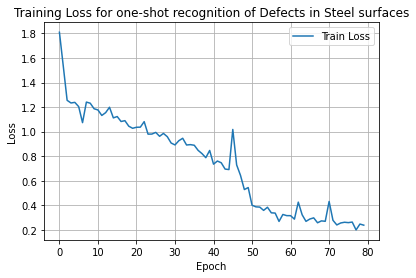

In [ ]:
training_data = np.array(Loss_training)
plt.title("Training Loss for one-shot recognition of Defects in Steel surfaces")
plt.plot(training_data, label="Train Loss")

plt.xlabel("Epoch")
plt.grid(True)
plt.ylabel("Loss")
plt.legend()
plt.show()

# Training the model on train data ( with pre processing )

In [ ]:
from skimage.morphology import disk
from skimage.filters.rank import median
import scipy.signal
from skimage.filters import rank
import skimage
import math
import skimage

def Pt(x0, y0, x1, y1):
   points = []
   dx, dy = abs(x1 - x0), abs(y1 - y0)
   x, y = x0, y0
   sx = -1 if x0 > x1 else 1
   sy = -1 if y0 > y1 else 1
   if dx > dy:
      err = dx /2
      while x != x1:
         points.append((x, y))
         err -= dy
         if err < 0:
            y += sy
            err += dx
         x += sx
   else:
      err = dy / 2.0
      while y != y1:
         points.append((x, y))
         err -= dx
         if err < 0:
            x += sx
            err += dy
         y += sy
   points.append((x, y))
   return points

def strel_line(length, degrees):
   if length >= 1:
      theta = degrees*np.pi/180
      x = round((length - 1) / 2 * np.cos(theta))
      y = -round((length - 1) / 2 * np.sin(theta))
      points = Pt(-x, -y, x, y)
      points_x = [point[0] for point in points]
      points_y = [point[1] for point in points]
      n_rows = int(2 * max([abs(point_y) for point_y in points_y]) + 1)
      n_columns = int(2 * max([abs(point_x) for point_x in points_x]) + 1)
      strel = np.zeros((n_rows, n_columns))
      rows = ([point_y + max([abs(point_y) for point_y in points_y]) for point_y in points_y])
      columns = ([point_x + max([abs(point_x) for point_x in points_x]) for point_x in points_x])
      idx = []
      for x in zip(rows, columns):
         idx.append(np.ravel_multi_index((int(x[0]), int(x[1])), (n_rows, n_columns)))
      strel.reshape(-1)[idx] = 1
      strel = strel.astype(np.uint8)
   return strel

def opening_img(medImg):
  SE = []
  for ii in range (6):
    SE.append(strel_line(15,ii*30))
  #medImg = cv2.cvtColor(medImg,cv2.COLOR_BGR2GRAY)
  imgOpen=np.zeros([6,np.shape(medImg)[0],np.shape(medImg)[1]])
  # Image opening in the six direction for each gray level image and Overlap Image to Single one
  for j in range (6):
    imgOpen[j]=cv2.morphologyEx(medImg, cv2.MORPH_OPEN, SE[j])
    if j==5:
      imgOverlap=imgOpen[0]
      for l in range (1,5):
        imgOverlap = cv2.addWeighted(imgOverlap,0.6,imgOpen[l],0.4,0.0) 
        # np.dstackdst = cv.addWeighted(src1, alpha, src2, beta, 0.0)
  return imgOverlap

def pre_processing3(img,d1,d2):
  img_rescale = skimage.exposure.equalize_hist(img)#clip_limit=0.1)
  #img_eq = rank.equalize(img, selem=disk(d1))
  #p2, p98 = np.percentile(img_rescale, (15, 85))
  #img_eq = skimage.exposure.rescale_intensity(img_rescale, in_range=(p2, p98))
  #noisy_image = cv2.medianBlur(np.uint16(img_rescale),3)
  #noise = np.random.random(noisy_image.shape)
  #noisy_image[noise > 0.99] = 225
  #noisy_image[noise < 0.01] = 30
  #img111 = median(np.uint8(noisy_image), disk(d2))
  img112 = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)
  img111 = opening_img(img112)
  #img111 = cv2.cvtColor(img112,cv2.COLOR_BGR2GRAY)
  #thresh, img112 = cv2.threshold(img111, 98, 255, cv2.THRESH_OTSU)
  return img111, img_rescale

In [ ]:
import cv2
train_loss = 0
Loss_training1 = []
optimizer = optim.Adam(siamese.parameters(), lr=LR)
N = len(datasets)

for epoch in range(N_EPOCHS):
    for batch_idx, data in enumerate(Load_train_data):
        imageA, imageB, label = data
        imageA1 = np.zeros(np.shape(imageA.numpy()))
        imageB1 = np.zeros(np.shape(imageA.numpy()))
        for ii in range(3):
          #a1 = cv2.cvtColor(imageA.numpy()[ii,0],cv2.COLOR_BGR2GRAY)
          #b1 = cv2.cvtColor(imageB.numpy()[ii,0],cv2.COLOR_BGR2GRAY)
          imageA1[ii,0],b = pre_processing3(imageA.numpy()[ii,0],76,3)
          imageB1[ii,0],b = pre_processing3(imageA.numpy()[ii,0],76,3)
        imageA = torch.from_numpy(imageA1).float()
        imageB = torch.from_numpy(imageB1).float()
        imageA, imageB, label = imageA.to(device), imageB.to(device), label.to(device)
        
        optimizer.zero_grad()
        #a1= 
        resultA, resultB = siamese(imageA, imageB)
        loss = contrastive_loss(resultA, resultB, label)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    BatchCount_PER_EPOCH = N//BATCH_SIZE
    train_loss = train_loss/BatchCount_PER_EPOCH
    Loss_training1.append(train_loss)
    
    print('Train Epoch:{}\t\tLoss:{:.6f}'.format(epoch+1, train_loss))
    train_loss = 0
    siamese.train()

Train Epoch:1		Loss:2.412798
Train Epoch:2		Loss:2.067979
Train Epoch:3		Loss:1.794174
Train Epoch:4		Loss:2.038640
Train Epoch:5		Loss:2.008999
Train Epoch:6		Loss:1.966150
Train Epoch:7		Loss:2.062677
Train Epoch:8		Loss:1.960045
Train Epoch:9		Loss:1.907810
Train Epoch:10		Loss:1.992083
Train Epoch:11		Loss:1.972108
Train Epoch:12		Loss:1.988992
Train Epoch:13		Loss:1.808484
Train Epoch:14		Loss:1.957001
Train Epoch:15		Loss:2.068751
Train Epoch:16		Loss:1.960109
Train Epoch:17		Loss:1.982436
Train Epoch:18		Loss:1.969147
Train Epoch:19		Loss:1.946003
Train Epoch:20		Loss:1.850355
Train Epoch:21		Loss:1.934634
Train Epoch:22		Loss:2.042942
Train Epoch:23		Loss:1.861941
Train Epoch:24		Loss:1.911742
Train Epoch:25		Loss:2.169693
Train Epoch:26		Loss:1.892672
Train Epoch:27		Loss:1.822695
Train Epoch:28		Loss:1.969218
Train Epoch:29		Loss:1.998601
Train Epoch:30		Loss:1.946989
Train Epoch:31		Loss:1.977760
Train Epoch:32		Loss:1.986077
Train Epoch:33		Loss:1.863276
Train Epoch:34		Los

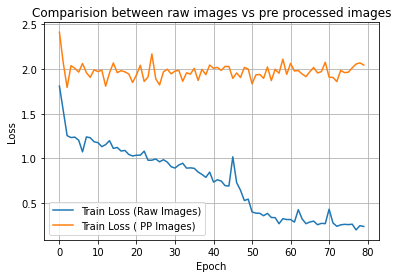

In [ ]:
training_data = np.array(Loss_training)
training_data1 = np.array(Loss_training1)
plt.title("Comparision between raw images vs pre processed images")
plt.plot(training_data, label="Train Loss (Raw Images)")
plt.plot(training_data1, label = "Train Loss ( PP Images)")
plt.xlabel("Epoch")
plt.grid(True)
plt.ylabel("Loss")
plt.legend()
plt.show()

# Results of model on test data (no pp)

In [ ]:
class_list = os.listdir(TEST_DIR)
class_list.sort()
test_datasets = torchvision.datasets.ImageFolder(root=TEST_DIR)
siamese_test_datasets = SiameseDataset(datasets=test_datasets,
                                       train=False,
                                       transform=transform,
                                       should_invert=False,
                                       set_luminance=SET_L)

In [ ]:
siamese.eval()

SiamaseNet(
  (conv_layer): Sequential(
    (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

 1
 1
 1
 1
 1
 1
 1
 0


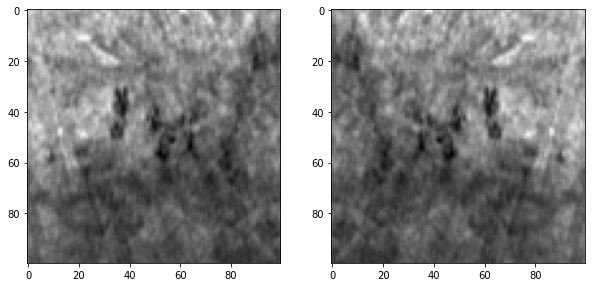

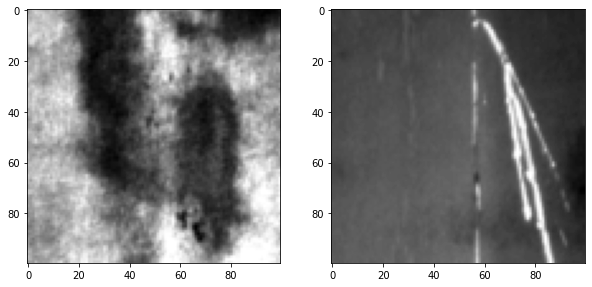

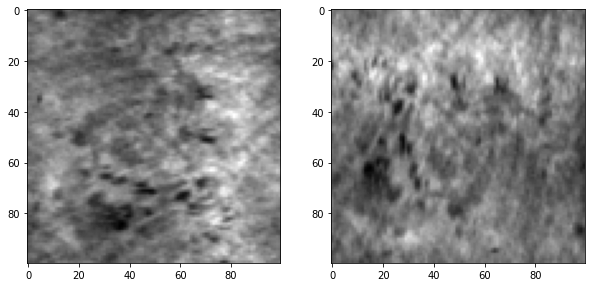

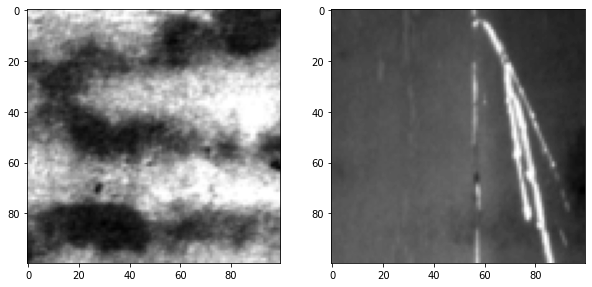

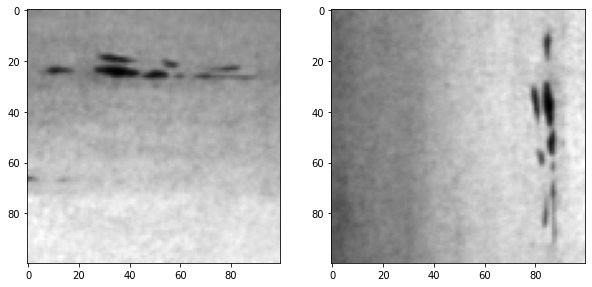

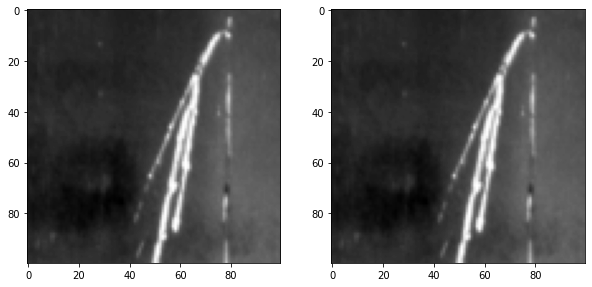

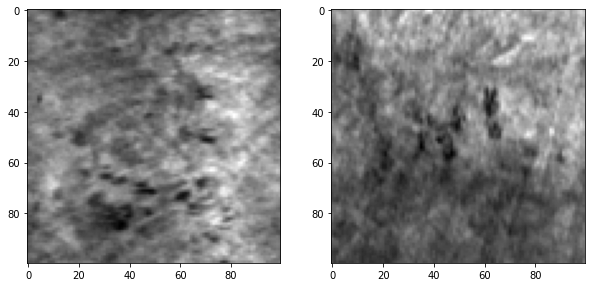

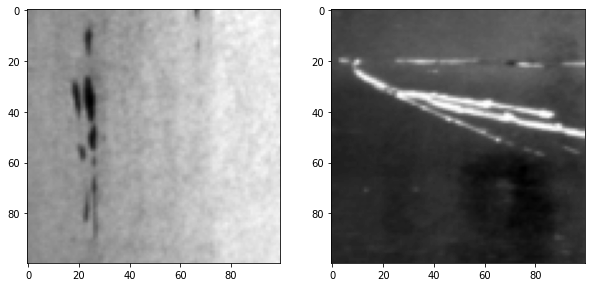

In [ ]:
test_loader = DataLoader(siamese_test_datasets, 
                         num_workers=0,
                         batch_size=1,
                         shuffle=True)

data_iter = iter(test_loader)

imageA, pathA, classA, _, _, _ = next(data_iter)


test_loader = DataLoader(siamese_test_datasets, 
                         num_workers=0,
                         batch_size=1,
                         shuffle=True)

data_iter = iter(test_loader)

correct_ = []
Distance=[]
count = 0
for i in range(len(siamese_test_datasets)):
    try:
        count += 1
        imageA, pathA, classA, imageB, pathB, classB = next(data_iter)
    except:
        break
    
    with torch.no_grad():
        resultA, resultB = siamese(Variable(imageA).to(device), Variable(imageB).to(device))
        euclidean_distance = F.pairwise_distance(resultA, resultB)
        Distance.append(euclidean_distance)
        if euclidean_distance>=1.4 and classA!=classB:
          correct_.append(1)
        elif euclidean_distance<1.4 and classA==classB:
          correct_.append(1)
        else:
          correct_.append(0)

    concatenated = torch.cat((imageA, imageB),0)
    print('',correct_[i])
    fig,plot= plt.subplots(1,2,figsize=(10,10))
    plot[0].imshow(concatenated.numpy()[0,0],cmap='gray')
    plot[1].imshow(concatenated.numpy()[1,0],cmap='gray')

In [ ]:
Distance

[tensor([0.0444]),
 tensor([2.0050]),
 tensor([0.0614]),
 tensor([1.6853]),
 tensor([0.7881]),
 tensor([2.2361e-06]),
 tensor([0.5007]),
 tensor([0.1636])]

In [ ]:
Accuracy = sum(correct_)/len(correct_)
Accuracy

0.875

# Results of model on test data ( with pp )

 1
 0
 1
 1
 1
 1
 1
 0


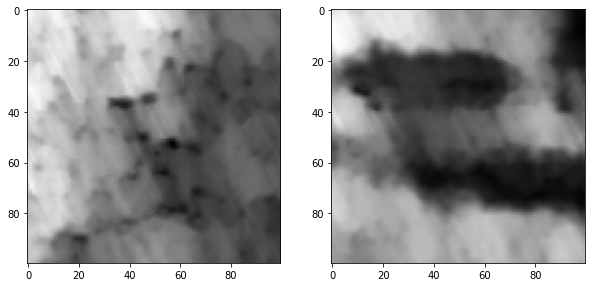

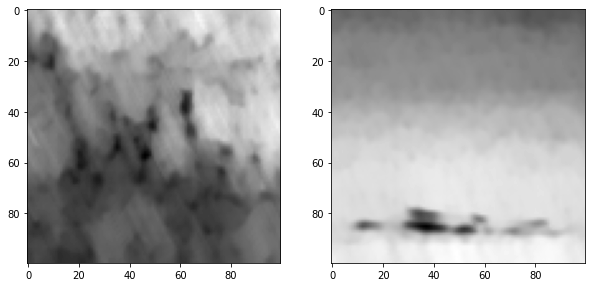

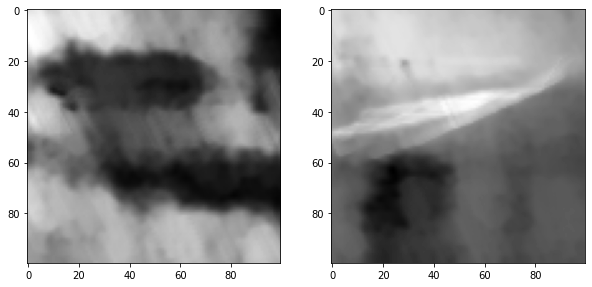

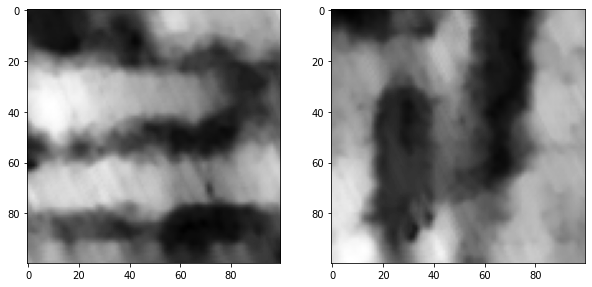

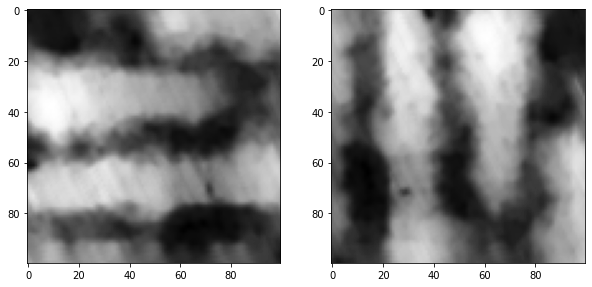

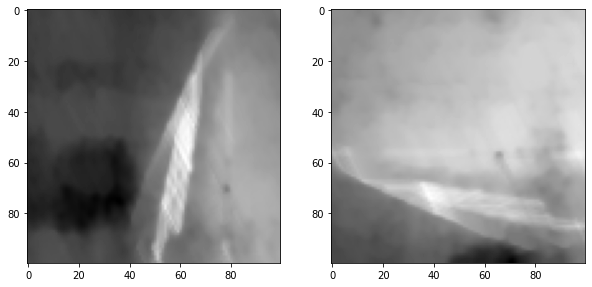

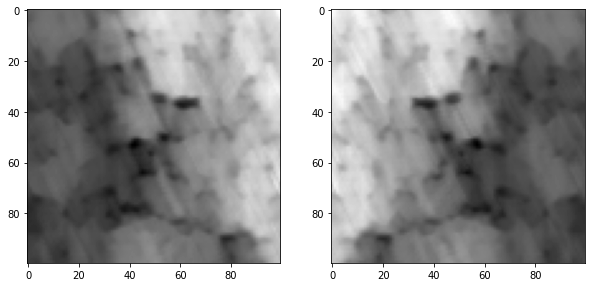

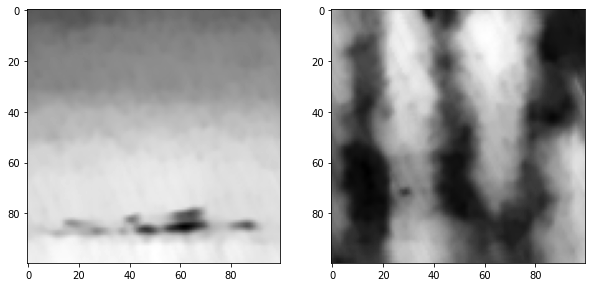

In [ ]:
test_loader = DataLoader(siamese_test_datasets, 
                         num_workers=0,
                         batch_size=1,
                         shuffle=True)

data_iter = iter(test_loader)

imageA, pathA, classA, _, _, _ = next(data_iter)


test_loader = DataLoader(siamese_test_datasets, 
                         num_workers=0,
                         batch_size=1,
                         shuffle=True)

data_iter = iter(test_loader)
correct_1 = []
Distance1=[]
count1 = 0
for i in range(len(siamese_test_datasets)):
    try:
        count1 += 1
        imageA, pathA, classA, imageB, pathB, classB = next(data_iter)
    except:
        break
    
    with torch.no_grad():
      imageA1 = np.zeros(np.shape(imageA.numpy()))
      imageB1 = np.zeros(np.shape(imageB.numpy()))
      imageA1[0,0],b = pre_processing3(imageA.numpy()[0,0],40,3)
      imageB1[0,0],b = pre_processing3(imageB.numpy()[0,0],40,3)
      imageA2 = torch.from_numpy(imageA1).float()
      imageB2 = torch.from_numpy(imageB1).float()
      resultA, resultB = siamese(Variable(imageA2).to(device), Variable(imageB2).to(device))
      euclidean_distance = F.pairwise_distance(resultA, resultB)
      Distance1.append(euclidean_distance)
      if euclidean_distance>=1.4 and classA!=classB:
        correct_1.append(1)
      elif euclidean_distance<1.4 and classA==classB:
        correct_1.append(1)
      else:
        correct_1.append(0)

    concatenated =torch.cat((imageA2, imageB2),0)
    print('',correct_1[i])
    fig,plot= plt.subplots(1,2,figsize=(10,10))
    plot[0].imshow(concatenated.numpy()[0,0],cmap='gray')
    plot[1].imshow(concatenated.numpy()[1,0],cmap='gray')

In [ ]:
Distance1

[tensor([1.4098]),
 tensor([0.2544]),
 tensor([1.5731]),
 tensor([0.5394]),
 tensor([0.2082]),
 tensor([0.1256]),
 tensor([0.0826]),
 tensor([0.8756])]

In [ ]:
Accuracy1 = sum(correct_1)/len(correct_1)
Accuracy1

0.75